<a href="https://colab.research.google.com/github/paulcodrea/dissertation/blob/main/7_LSTM_prediction_BTC_price_and_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import LSTM
# from keras.optimizers import Adam
from time import time
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [4]:
df = pd.read_csv('/content/hour_df_merged.csv', parse_dates=True, index_col="date")
# df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
print(df.head())

                      compund  positive  negative   neutral         score  \
date                                                                        
2022-02-28 06:00:00  0.287929  0.162010  0.039107  0.798886  3.371586e-07   
2022-02-28 06:00:00  0.310226  0.161295  0.030119  0.808586  7.133069e-07   
2022-02-28 07:00:00  0.292630  0.175125  0.053626  0.771263  6.261388e-07   
2022-02-28 08:00:00  0.222387  0.142660  0.044789  0.812554  2.533715e-07   
2022-02-28 09:00:00  0.284290  0.157970  0.033426  0.808592  3.017866e-07   

                        close  
date                           
2022-02-28 06:00:00  37988.12  
2022-02-28 06:00:00  37988.12  
2022-02-28 07:00:00  38367.83  
2022-02-28 08:00:00  38331.54  
2022-02-28 09:00:00  38129.88  


In [6]:
# Data normalization. This is one of the first steps to normalize the values. 
# The goal is to change the values of numeric columns in the data set to a common scale, wihtout distorting differeces in the randes of values. 
df_values = df.values
sc = MinMaxScaler()
data_scaled = sc.fit_transform(df_values)

print(len(data_scaled))
print(data_scaled.size)
print(data_scaled)

189
1134
[[0.28904909 0.32895595 0.64467002 0.54850791 0.09310384 0.07378742]
 [0.3509508  0.32517021 0.42470203 0.60054291 0.18825591 0.07378742]
 [0.30210086 0.39839323 1.         0.40033051 0.16620548 0.12525482]
 ...
 [0.13764991 0.24638118 0.6646457  0.62773994 0.10908592 0.2157765 ]
 [0.32022031 0.3199012  0.42472574 0.60580017 0.0752845  0.23186964]
 [0.21774567 0.28236223 0.69968976 0.58358916 0.07571006 0.18137409]]


In [7]:
# Splitting data into training and testing data 

train_index = int(0.6 * len(data_scaled))
val_index = train_index + int(0.1 * len(data_scaled))

train = data_scaled[:train_index]
val = data_scaled[train_index:val_index]
test = data_scaled[val_index:]

In [8]:
print("train,test,val",train.shape, test.shape, val.shape)

train,test,val (113, 6) (58, 6) (18, 6)


In [9]:
# Get xtrain and ytrain
xtrain, ytrain = train[:, :6], train[:, 4]
# Get xtest and ytest
xtest, ytest = test[:, :6], test[:, 4]
# Get xval and yval
xval, yval = val[:, :6], val[:, 4]

In [10]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)
print(xval.shape)
print(yval.shape)

(113, 6)
(113,)
(58, 6)
(58,)
(18, 6)
(18,)


In [20]:
lookback = 1
n_features = 6
train_len = len(xtrain) - lookback
test_len = len(xtest) - lookback
val_len = len(xval) - lookback

print("Train len:", train_len)
print("Test len:", test_len)

x_train = np.zeros((train_len, lookback, n_features))
y_train = np.zeros((train_len))
for i in range(train_len):
    ytemp = i+lookback
    x_train[i] = xtrain[i:ytemp]
    y_train[i] = ytrain[ytemp]
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_test = np.zeros((test_len, lookback, n_features))
y_test = np.zeros((test_len))
for i in range(test_len):
    ytemp = i+lookback
    x_test[i] = xtest[i:ytemp]
    y_test[i] = ytest[ytemp]
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_val = np.zeros((val_len, lookback, n_features))
y_val = np.zeros((val_len))
for i in range(val_len):
    ytemp = i+lookback
    x_val[i] = xval[i:ytemp]
    y_val[i] = yval[ytemp]
print("x_val", x_val.shape)
print("y_val", y_val.shape)

model = Sequential()  
model.add(LSTM(600,input_shape = (lookback, n_features), return_sequences=True))
model.add(LSTM(700))
model.add(Dropout(0.15))
model.add(Dense(1))
print(model.summary())

model.compile(loss = 'mse', optimizer = 'adam')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')

start = time()
print("start:",0)
history = model.fit(x_train,y_train, epochs = 20, batch_size=4, 
          validation_data=(x_val,y_val),verbose = 1, 
          shuffle = False, callbacks=[earlystop])
print("endtime:",time()-start)

Train len: 112
Test len: 57
x_train (112, 1, 6)
y_train (112,)
x_test (57, 1, 6)
y_test (57,)
x_val (17, 1, 6)
y_val (17,)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 600)            1456800   
                                                                 
 lstm_9 (LSTM)               (None, 700)               3642800   
                                                                 
 dropout_4 (Dropout)         (None, 700)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 701       
                                                                 
Total params: 5,100,301
Trainable params: 5,100,301
Non-trainable params: 0
_________________________________________________________________
None
start: 0
Epoch 1/20
28/28 [=====================

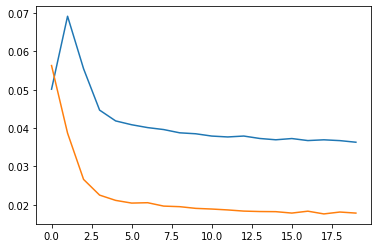

r2_score: -7.765864897138199


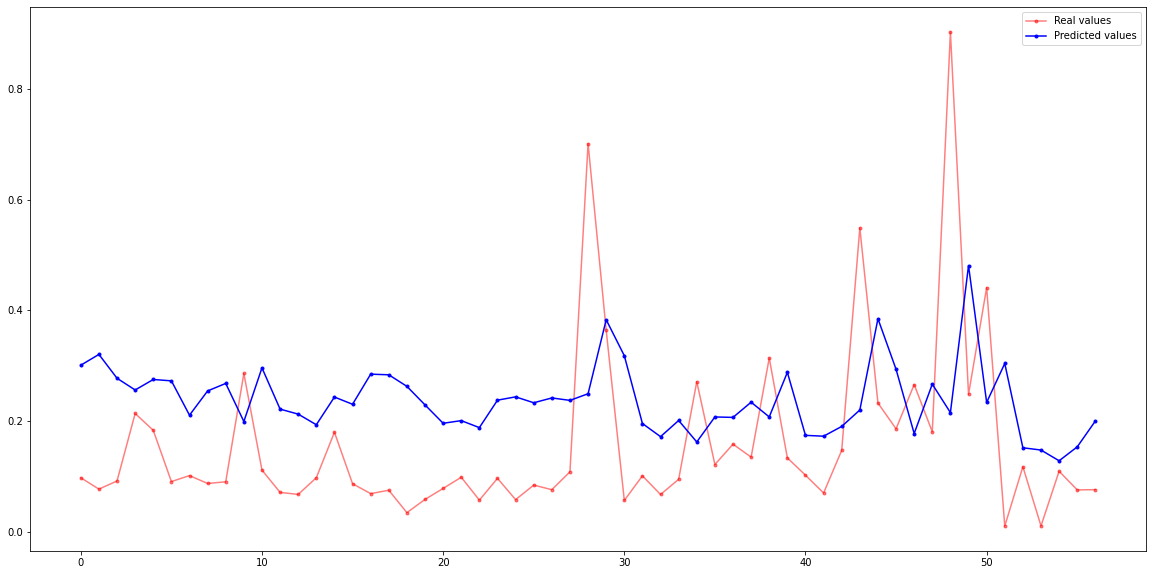

In [21]:
loss = history.history
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])
plt.show()


y_pred = model.predict(x_test)

print("r2_score:",r2_score(y_pred,y_test))

plt.figure(figsize=(20,10))
plt.plot( y_test, '.-', color='red', label='Real values', alpha=0.5)
plt.plot( y_pred, '.-', color='blue', label='Predicted values', alpha=1)
plt.legend()
plt.show()